In [12]:

!pip install tensorflow


In [13]:
from datetime import timedelta, datetime
import pandas as pd
import numpy as np

import cufflinks as cf
import chart_studio.plotly as plotly
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=True, world_readable=False)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, LeakyReLU
import yfinance as yf
from PyEMD import CEEMDAN

# iplot layout
space =  {
            'legend' : {'bgcolor':'#1A1A1C','font':{'color':'#D9D9D9',"size":12}},
            'paper_bgcolor' : '#1A1A1C',
            'plot_bgcolor' : '#1A1A1C',
            "title" : {"font":{"color":"#D9D9D9"},"x":0.5},
            'yaxis' : {
                'tickfont' : {'color':'#C2C2C2', "size":12},
                'gridcolor' : '#434343',
                'titlefont' : {'color':'#D9D9D9'},
                'zerolinecolor' : '#666570',
                'showgrid' : True
            },
            'xaxis' : {
                'tickfont' : {'color':'#C2C2C2', "size":12},
                'gridcolor' : '#434343',
                'titlefont' : {'color':'#D9D9D9'},
                'zerolinecolor' : '#666570',
                'showgrid' : True
            },
            'titlefont' : {'color':'#D9D9D9'}
        }

In [20]:
tickers = ["PETR4", "VALE3", "BOVA11", "ITUB4", "BBDC4", "B3SA3", "BBAS3", "ABEV3", "MGLU3"]

tickers = [f"{ticker}.SA" for ticker in tickers]

start_datetime = datetime(year=2023, month=7, day=20)
end_datetime = datetime(year=2023, month=12, day=2)

history_data = {ticker.split('.')[0]:yf.download(ticker, start=start_datetime, end=end_datetime).drop(['Close','Open', 'High', 'Low', 'Volume'], axis=1).dropna() for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [21]:
%%time
ceemdan = CEEMDAN()
decomposed_data = {}
decomposed_ticker_features_series = {}
scalers = {}
for ticker in history_data:
    # iterating every ticker
    print(f'[{ticker}] Decomposing...')
    ticker_dataframe = history_data[ticker]
    decomposed_ticker_features_series[ticker] = {}
    scalers[ticker] = {}
    for column in ticker_dataframe.columns:
        # iterating evey feature
        scaler = MinMaxScaler()
        decomposed_ticker_features_series[ticker][column] = {}
        series = ticker_dataframe[column].values.reshape(-1,1)
        scaler.fit(series)
        scalers[ticker][column] = scaler
        ticker_feature_time_series = np.frombuffer(scaler.transform(series))
        ticker_feature_time_series_imfs = ceemdan(ticker_feature_time_series, max_imf=10)
        for i, imf_series in enumerate(ticker_feature_time_series_imfs):
            # iterating every IMF 
            if i < len(ticker_feature_time_series_imfs):
                decomposed_ticker_features_series[ticker][column][f'IMF{i+1}'] = imf_series
            else:
                decomposed_ticker_features_series[ticker][column][f'Rsd'] = imf_series

[PETR4] Decomposing...
[VALE3] Decomposing...
[BOVA11] Decomposing...
[ITUB4] Decomposing...
[BBDC4] Decomposing...
[B3SA3] Decomposing...
[BBAS3] Decomposing...
[ABEV3] Decomposing...
[MGLU3] Decomposing...
CPU times: total: 10.5 s
Wall time: 21.7 s


In [63]:
print(decomposed_ticker_features_series)

{'PETR4': {'Adj Close': {'IMF1': array([-0.10211043, -0.04381323,  0.01921392,  0.08728148,  0.08665091,
       -0.07056476, -0.05537733,  0.04533506, -0.02005413, -0.0291414 ,
        0.02732533, -0.02870046,  0.00727371,  0.01571708,  0.03393802,
        0.03824222,  0.0108077 , -0.00965418, -0.02182477,  0.01162157,
       -0.00528762,  0.00915748, -0.02988159, -0.0387114 ,  0.050548  ,
       -0.00481965, -0.05227227, -0.02088356, -0.00354246,  0.03090666,
       -0.02854689,  0.02984599, -0.03089303,  0.02883907,  0.00549109,
       -0.02170481, -0.01376224,  0.02390854, -0.02481519,  0.0207258 ,
       -0.01226281, -0.0044564 , -0.00013141,  0.01399237, -0.0259322 ,
        0.01351406,  0.043623  , -0.03965203,  0.02688429, -0.01245308,
        0.00537934, -0.01234786,  0.03176105, -0.05292804, -0.04751793,
       -0.01615067,  0.06284086,  0.03241952, -0.03162557,  0.0193054 ,
       -0.01521976,  0.01050511,  0.05287013,  0.05067772,  0.06882532,
       -0.08527343,  0.03418829

In [22]:
# Data organisation
features_in_order = ['Adj Close']

max_window_size = 10
windows_sizes_for_imf_level = {
    'IMF1': 2,
    'IMF2': 2,
    'IMF3': 3,
    'IMF4': 3,
    'IMF5': 4,
    'IMF6': 4,
    'IMF7': 5,
    'IMF8': 5,
    'Rsd': 6,
    'DEFAULT': 4
}

# Coupling together the IMFs of the same level for different features to create exogenous input
# The number of imfs for each feature decomposition may differ, thus some of the last imfs may not match in number of features
series = {}
for ticker in decomposed_ticker_features_series:
    series[ticker] = {}
    for feature in decomposed_ticker_features_series[ticker]:
        imfs = pd.DataFrame.from_dict(decomposed_ticker_features_series[ticker][feature])
        for imf in imfs:
            if imf not in series[ticker]:
                series[ticker][imf] = []
            _series = imfs[imf].values
            _series = _series.reshape((len(_series),1))
            series[ticker][imf] += [_series] # reshaping to get into column format

dataset = {}
# # horizontal stack
for ticker in series:
    dataset[ticker] = {}
    for imf_level in series[ticker]:
        dataset[ticker][imf_level] = np.hstack(tuple(series[ticker][imf_level]))

# # data set split rates
train = 0.7
validation = 0.2
test = 0.1

train_dataset = {}
validation_dataset = {}
test_dataset = {}

train_generators = {}
validation_generators = {}
test_generators = {}

for ticker in dataset:

    train_dataset[ticker] = {}
    validation_dataset[ticker] = {}
    test_dataset[ticker] = {}

    train_generators[ticker] = {}
    validation_generators[ticker] = {}
    test_generators[ticker] = {}

    for imf_level in dataset[ticker]:
        # splitting data sets according to rates
        train_dataset[ticker][imf_level] = dataset[ticker][imf_level][:round(train*dataset[ticker][imf_level].shape[0]),:]
        validation_dataset[ticker][imf_level] = dataset[ticker][imf_level][round(train*dataset[ticker][imf_level].shape[0]):round((train+validation)*dataset[ticker][imf_level].shape[0]),:]
        test_dataset[ticker][imf_level] = dataset[ticker][imf_level][round((train+validation)*dataset[ticker][imf_level].shape[0]):,:]

        if imf_level in windows_sizes_for_imf_level:
            window_size = windows_sizes_for_imf_level[imf_level]
        else: 
            window_size = windows_sizes_for_imf_level['DEFAULT']
        # windowing
        train_generators[ticker][imf_level] = TimeseriesGenerator(train_dataset[ticker][imf_level], train_dataset[ticker][imf_level], length=window_size, batch_size=1)
        validation_generators[ticker][imf_level] = TimeseriesGenerator(validation_dataset[ticker][imf_level], validation_dataset[ticker][imf_level], length=window_size, batch_size=1)
        test_generators[ticker][imf_level] = TimeseriesGenerator(test_dataset[ticker][imf_level], test_dataset[ticker][imf_level], length=window_size, batch_size=1)


In [29]:
%%time
# Model Training

models = {}

model_epochs = {
    'IMF1': 2000,
    'IMF2': 1500,
    'IMF3': 1000,
    'IMF4': 1000,
    'IMF5': 1000,
    'IMF6': 800,
    'IMF7': 800,
    'IMF8': 600,
    'Rsd': 500,
    'DEFAULT': 1000
}

for ticker in train_generators:
    models[ticker] = {}
    for imf_level in train_generators[ticker]:
        print(f'Training model [{ticker}][{imf_level}]')
        # Prediction model
        model = Sequential()
        current_dataset = train_dataset[ticker][imf_level]
        n_features = current_dataset.shape[1]
        cur_tmp_gen = train_generators[ticker][imf_level]

        if imf_level in windows_sizes_for_imf_level:
            window_size = windows_sizes_for_imf_level[imf_level]
        else: 
            window_size = windows_sizes_for_imf_level['DEFAULT']

        model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(window_size, n_features)))
        model.add(LSTM(64, activation='tanh', input_shape=(window_size, 128)))
        model.add(Dense(16))
        model.add(Dense(4))
        model.add(Dense(n_features))
        model.compile(optimizer='adam', loss='mse')

        number_of_epochs = model_epochs[imf_level]
        # fit model
        model.fit_generator(cur_tmp_gen, steps_per_epoch=1, epochs=number_of_epochs, verbose=0)

        models[ticker][imf_level] = model

Training model [PETR4][IMF1]


<timed exec>:42: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Training model [PETR4][IMF2]
Training model [PETR4][IMF3]
Training model [PETR4][IMF4]
Training model [VALE3][IMF1]
Training model [VALE3][IMF2]
Training model [VALE3][IMF3]
Training model [VALE3][IMF4]
Training model [BOVA11][IMF1]
Training model [BOVA11][IMF2]
Training model [BOVA11][IMF3]
Training model [BOVA11][IMF4]
Training model [BOVA11][IMF5]
Training model [ITUB4][IMF1]
Training model [ITUB4][IMF2]
Training model [ITUB4][IMF3]
Training model [ITUB4][IMF4]
Training model [BBDC4][IMF1]
Training model [BBDC4][IMF2]
Training model [BBDC4][IMF3]
Training model [BBDC4][IMF4]
Training model [B3SA3][IMF1]
Training model [B3SA3][IMF2]
Training model [B3SA3][IMF3]
Training model [BBAS3][IMF1]
Training model [BBAS3][IMF2]
Training model [BBAS3][IMF3]
Training model [BBAS3][IMF4]
Training model [BBAS3][IMF5]
Training model [ABEV3][IMF1]
Training model [ABEV3][IMF2]
Training model [ABEV3][IMF3]
Training model [ABEV3][IMF4]
Training model [ABEV3][IMF5]
Training model [MGLU3][IMF1]
Training 

In [32]:
results = {}

for ticker in models:
    results[ticker] = {}

    # initializing results dicitionary
    for feature in features_in_order:
        results[ticker][feature] = {}
        for imf_level in models[ticker]:
            results[ticker][feature][imf_level] = {
                'real_train': [],
                'predicted_train': [],
                'real_validation': [],
                'predicted_validation': [],
                'real_test': [],
                'predicted_test': [],
                'x_axis_train': [],
                'x_axis_validation': [],
                'x_axis_test': []
            }

    for imf_level in models[ticker]:
        model = models[ticker][imf_level]
        
        print(f'Predicting: [{ticker}][{imf_level}]')

        cur_train_gen = train_generators[ticker][imf_level]
        cur_validation_gen = validation_generators[ticker][imf_level]
        cur_test_gen = test_generators[ticker][imf_level]

        # predicting train
        day_counter = 0
        for i in range(len(cur_train_gen)):
            x, y = cur_train_gen[i]
            yhat = model.predict(x, verbose=0)

            for j in range(yhat.shape[1]):
                results[ticker][features_in_order[j]][imf_level]['real_train'] += [y[:,j][0]]
                results[ticker][features_in_order[j]][imf_level]['predicted_train'] += [yhat[:,j][0]]
                results[ticker][features_in_order[j]][imf_level]['x_axis_train'] += [day_counter]
            day_counter += 1

        # predicting validation
        for i in range(len(cur_validation_gen)):
            x, y = cur_validation_gen[i]
            yhat = model.predict(x, verbose=0)

            for j in range(yhat.shape[1]):
                results[ticker][features_in_order[j]][imf_level]['real_validation'] += [y[:,j][0]]
                results[ticker][features_in_order[j]][imf_level]['predicted_validation'] += [yhat[:,j][0]]
                results[ticker][features_in_order[j]][imf_level]['x_axis_validation'] += [day_counter]
            day_counter += 1

        # predicting test
        for i in range(len(cur_test_gen)):
            x, y = cur_test_gen[i]
            yhat = model.predict(x, verbose=0)

            for j in range(yhat.shape[1]):
                results[ticker][features_in_order[j]][imf_level]['real_test'] += [y[:,j][0]]
                results[ticker][features_in_order[j]][imf_level]['predicted_test'] += [yhat[:,j][0]]
                results[ticker][features_in_order[j]][imf_level]['x_axis_test'] += [day_counter]
            day_counter += 1


Predicting: [PETR4][IMF1]
Predicting: [PETR4][IMF2]
Predicting: [PETR4][IMF3]
Predicting: [PETR4][IMF4]
Predicting: [VALE3][IMF1]
Predicting: [VALE3][IMF2]
Predicting: [VALE3][IMF3]
Predicting: [VALE3][IMF4]
Predicting: [BOVA11][IMF1]
Predicting: [BOVA11][IMF2]
Predicting: [BOVA11][IMF3]
Predicting: [BOVA11][IMF4]
Predicting: [BOVA11][IMF5]
Predicting: [ITUB4][IMF1]
Predicting: [ITUB4][IMF2]
Predicting: [ITUB4][IMF3]
Predicting: [ITUB4][IMF4]
Predicting: [BBDC4][IMF1]
Predicting: [BBDC4][IMF2]
Predicting: [BBDC4][IMF3]
Predicting: [BBDC4][IMF4]
Predicting: [B3SA3][IMF1]
Predicting: [B3SA3][IMF2]
Predicting: [B3SA3][IMF3]
Predicting: [BBAS3][IMF1]
Predicting: [BBAS3][IMF2]
Predicting: [BBAS3][IMF3]
Predicting: [BBAS3][IMF4]
Predicting: [BBAS3][IMF5]
Predicting: [ABEV3][IMF1]
Predicting: [ABEV3][IMF2]
Predicting: [ABEV3][IMF3]
Predicting: [ABEV3][IMF4]
Predicting: [ABEV3][IMF5]
Predicting: [MGLU3][IMF1]
Predicting: [MGLU3][IMF2]
Predicting: [MGLU3][IMF3]
Predicting: [MGLU3][IMF4]


In [33]:
# organizing imf prediction results, concatenating train, validation and test
concatenated_results = {}

for ticker in results:
    concatenated_results[ticker] = {}
    for feature in results[ticker]:
        concatenated_results[ticker][feature] = {}
        for imf_level in results[ticker][feature]:
            
            df_result = pd.DataFrame.from_dict(results[ticker][feature][imf_level], orient='index').T
            df_train = df_result[['real_train','predicted_train','x_axis_train']].set_index('x_axis_train').dropna(axis=0)
            df_train.index.name = 'x'
            df_validation = df_result[['real_validation','predicted_validation','x_axis_validation']].set_index('x_axis_validation').dropna(axis=0)
            df_validation.index.name = 'x'
            df_test = df_result[['real_test','predicted_test','x_axis_test']].set_index('x_axis_test').dropna(axis=0)
            df_test.index.name = 'x'

            df_concatenated = pd.concat([df_train,df_validation,df_test], axis=1)

            concatenated_results[ticker][feature][imf_level] = df_concatenated

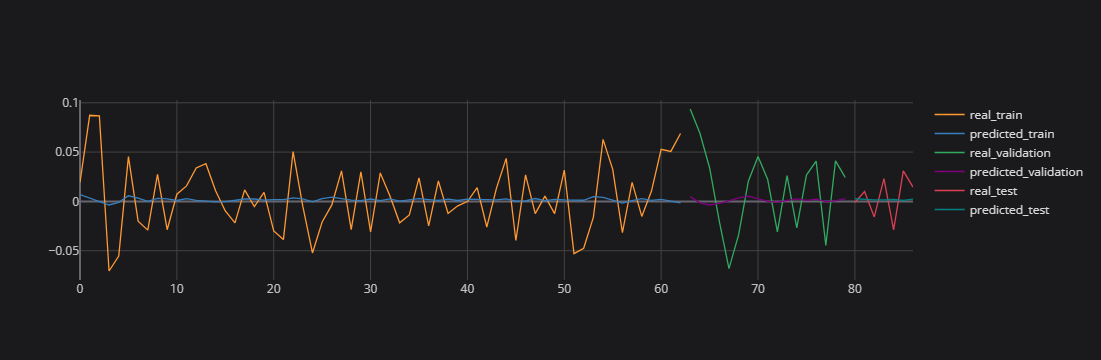

In [39]:
# plotting partial result
plot_ticker = 'PETR4'
plot_feature = 'Adj Close'
plot_imf = 'IMF1'

concatenated_results[plot_ticker][plot_feature][plot_imf].iplot(title=f'{plot_ticker} {plot_feature} {plot_imf}', asFigure=True, layout=space)

In [43]:
concatenated_results_copy = concatenated_results.copy()
accuracies_per_imf_detailed = {}

for ticker in concatenated_results_copy:
    accuracies_per_imf_detailed[ticker] = {}
    for feature in concatenated_results_copy[ticker]:
        # we are predicting only Adj Close, so we don't need to specify which feature we are predicting here
        # accuracies_per_imf_detailed[ticker][feature] = {}
        for imf_level in concatenated_results_copy[ticker][feature]:
            real_test = concatenated_results_copy[ticker][feature][imf_level]['real_test'].values
            predicted_test = concatenated_results_copy[ticker][feature][imf_level]['predicted_test'].values
            real_validation = concatenated_results_copy[ticker][feature][imf_level]['real_validation'].values
            predicted_validation = concatenated_results_copy[ticker][feature][imf_level]['predicted_validation'].values
            real_train = concatenated_results_copy[ticker][feature][imf_level]['real_train'].values
            predicted_train = concatenated_results_copy[ticker][feature][imf_level]['predicted_train'].values

            # removing offset nan
            real_test = real_test[~np.isnan(real_test)]
            predicted_test = predicted_test[~np.isnan(predicted_test)]
            real_validation = real_validation[~np.isnan(real_validation)]
            predicted_validation = predicted_validation[~np.isnan(predicted_validation)]
            real_train = real_train[~np.isnan(real_train)]
            predicted_train = predicted_train[~np.isnan(predicted_train)]

            accuracies_per_imf_detailed[ticker][f'mse_test_{imf_level}'] = mean_squared_error(real_train,predicted_train)
            accuracies_per_imf_detailed[ticker][f'mape_test_{imf_level}'] = np.mean(np.abs((real_train - predicted_train) / real_train)) * 100

            # we sre only interested in the test accuracy here, so no need for specifying train and validation accuracies
            # accuracies_per_imf_detailed[ticker] = {
            #     'mse_train':mean_squared_error(real_test,predicted_test),
            #     'mse_validation':mean_squared_error(real_validation,predicted_validation),
            #     'mse_test':mean_squared_error(real_train,predicted_train),
            #     'mape_train':np.mean(np.abs((real_test - predicted_test) / real_test)) * 100,
            #     'mape_validation':np.mean(np.abs((real_validation - predicted_validation) / real_validation)) * 100,
            #     'mape_test':np.mean(np.abs((real_train - predicted_train) / real_train)) * 100,
            # }

df_accuracies_by_imfs = pd.DataFrame.from_dict(accuracies_per_imf_detailed)
df_accuracies_by_imfs.to_csv(f'exp_records_accuracy_per_imf/lstm_ceemdan_per_imf_{datetime.now().strftime("%H_%M_%S_%m_%d_%Y")}.csv', sep=',', encoding='utf-8')
df_accuracies_by_imfs

,PETR4,VALE3,BOVA11,ITUB4,BBDC4,B3SA3,BBAS3,ABEV3,MGLU3
mse_test_IMF1,0.001174,0.001440,0.001397,0.001657,0.001321,0.000821,0.000941,6.905142e-04,0.000601
mape_test_IMF1,129.633351,120.656445,211.283661,107.330511,148.168551,137.255813,184.401308,1.187801e+02,100.697495
mse_test_IMF2,0.000149,0.000099,0.000100,0.000250,0.000353,0.000211,0.000190,1.138166e-04,0.000255
mape_test_IMF2,72.640668,52.844889,99.595670,70.886504,66.729120,77.123199,331.653712,1.056320e+02,114.265345
mse_test_IMF3,0.000015,0.000024,0.000022,0.000015,0.000049,0.000483,0.000017,8.410438e-06,0.000009
mape_test_IMF3,26.178496,8.521509,24.075843,19.542128,26.456814,5.743205,34.978694,1.621362e+01,21.830369
mse_test_IMF4,0.000016,0.000027,0.000097,0.000378,0.007116,NaN,0.000021,6.140065e-05,0.000057
mape_test_IMF4,1.430389,1.743090,111.278240,9.811524,14.297581,NaN,36.107191,4.401264e+00,1.159578
mse_test_IMF5,NaN,NaN,0.000113,NaN,NaN,NaN,0.000008,6.466252e-07,NaN
mape_test_IMF5,NaN,NaN,3.438098,NaN,NaN,NaN,2.562687,1.642202e-01,NaN


In [44]:
# recomposing prediction by arithmetically adding the IMF curves

final_prediction_results = {}
max_window_size = 10

for ticker in concatenated_results:
    final_prediction_results[ticker] = {}
    for feature in concatenated_results[ticker]:
        addition_train = None
        addition_validation = None
        addition_test = None

        addition_real_train = None
        addition_real_validation = None
        addition_real_test = None

        # recomposing predictions
        for imf_level in concatenated_results[ticker][feature]:
            # adding test
            can_sum = True
            if addition_test is None:
                addition_test = concatenated_results[ticker][feature][imf_level]['predicted_test'].values
            else:
                np_array_to_be_added = concatenated_results[ticker][feature][imf_level]['predicted_test'].values
                cur_length = addition_test.shape[0]
                next_np_array_length = np_array_to_be_added.shape[0]
                if cur_length < next_np_array_length:
                    if next_np_array_length-cur_length < max_window_size:
                        np_array_to_be_added = np_array_to_be_added[next_np_array_length-cur_length:]
                    else:
                        can_sum = False
                else: 
                    if cur_length-next_np_array_length < max_window_size:
                        addition_test = addition_test[cur_length-next_np_array_length:]
                    else:
                        can_sum = False
                
                if can_sum:
                    addition_test = np.add(addition_test,np_array_to_be_added)

        for imf_level in concatenated_results[ticker][feature]:
            # adding train
            can_sum = True
            if addition_train is None:
                addition_train = concatenated_results[ticker][feature][imf_level]['predicted_train'].values
            else:
                np_array_to_be_added = concatenated_results[ticker][feature][imf_level]['predicted_train'].values
                cur_length = addition_train.shape[0]
                next_np_array_length = np_array_to_be_added.shape[0]
                if cur_length < next_np_array_length:
                    if next_np_array_length-cur_length < max_window_size:
                        np_array_to_be_added = np_array_to_be_added[next_np_array_length-cur_length:]
                    else:
                        can_sum = False
                else: 
                    if cur_length-next_np_array_length < max_window_size:
                        addition_train = addition_train[cur_length-next_np_array_length:]
                    else:
                        can_sum = False
                
                if can_sum:
                    addition_train = np.add(addition_train,np_array_to_be_added)

        for imf_level in concatenated_results[ticker][feature]:
            # adding validation
            can_sum = True
            if addition_validation is None:
                addition_validation = concatenated_results[ticker][feature][imf_level]['predicted_validation'].values
            else:
                np_array_to_be_added = concatenated_results[ticker][feature][imf_level]['predicted_validation'].values
                cur_length = addition_validation.shape[0]
                next_np_array_length = np_array_to_be_added.shape[0]
                if cur_length < next_np_array_length:
                    if next_np_array_length-cur_length < max_window_size:
                        np_array_to_be_added = np_array_to_be_added[next_np_array_length-cur_length:]
                    else:
                        can_sum = False
                else: 
                    if cur_length-next_np_array_length < max_window_size:
                        addition_validation = addition_validation[cur_length-next_np_array_length:]
                    else:
                        can_sum = False
                
                if can_sum:
                    addition_validation = np.add(addition_validation,np_array_to_be_added)

        # recomposing real
        for imf_level in concatenated_results[ticker][feature]:
            # adding test
            can_sum = True
            if addition_real_test is None:
                addition_real_test = concatenated_results[ticker][feature][imf_level]['real_test'].values
            else:
                np_array_to_be_added = concatenated_results[ticker][feature][imf_level]['real_test'].values
                cur_length = addition_real_test.shape[0]
                next_np_array_length = np_array_to_be_added.shape[0]
                if cur_length < next_np_array_length:
                    if next_np_array_length-cur_length < max_window_size:
                        np_array_to_be_added = np_array_to_be_added[next_np_array_length-cur_length:]
                    else:
                        can_sum = False
                else: 
                    if cur_length-next_np_array_length < max_window_size:
                        addition_real_test = addition_real_test[cur_length-next_np_array_length:]
                    else:
                        can_sum = False
                
                if can_sum:
                    addition_real_test = np.add(addition_real_test,np_array_to_be_added)

        for imf_level in concatenated_results[ticker][feature]:
            # adding train
            can_sum = True
            if addition_real_train is None:
                addition_real_train = concatenated_results[ticker][feature][imf_level]['real_train'].values
            else:
                np_array_to_be_added = concatenated_results[ticker][feature][imf_level]['real_train'].values
                cur_length = addition_real_train.shape[0]
                next_np_array_length = np_array_to_be_added.shape[0]
                if cur_length < next_np_array_length:
                    if next_np_array_length-cur_length < max_window_size:
                        np_array_to_be_added = np_array_to_be_added[next_np_array_length-cur_length:]
                    else:
                        can_sum = False
                else: 
                    if cur_length-next_np_array_length < max_window_size:
                        addition_real_train = addition_real_train[cur_length-next_np_array_length:]
                    else:
                        can_sum = False
                
                if can_sum:
                    addition_real_train = np.add(addition_real_train,np_array_to_be_added)

        for imf_level in concatenated_results[ticker][feature]:
            # adding validation
            can_sum = True
            if addition_real_validation is None:
                addition_real_validation = concatenated_results[ticker][feature][imf_level]['real_validation'].values
            else:
                np_array_to_be_added = concatenated_results[ticker][feature][imf_level]['real_validation'].values
                cur_length = addition_real_validation.shape[0]
                next_np_array_length = np_array_to_be_added.shape[0]
                if cur_length < next_np_array_length:
                    if next_np_array_length-cur_length < max_window_size:
                        np_array_to_be_added = np_array_to_be_added[next_np_array_length-cur_length:]
                    else:
                        can_sum = False
                else: 
                    if cur_length-next_np_array_length < max_window_size:
                        addition_real_validation = addition_real_validation[cur_length-next_np_array_length:]
                    else:
                        can_sum = False
                
                if can_sum:
                    addition_real_validation = np.add(addition_real_validation,np_array_to_be_added)
        
        scaler = scalers[ticker][feature]

        final_prediction_results[ticker][feature] = {
            'train_predicted': scaler.inverse_transform(addition_train.reshape(-1,1)).reshape(-1),
            'validation_predicted': scaler.inverse_transform(addition_validation.reshape(-1,1)).reshape(-1),
            'test_predicted': scaler.inverse_transform(addition_test.reshape(-1,1)).reshape(-1),
            'train_real': scaler.inverse_transform(addition_real_train.reshape(-1,1)).reshape(-1),
            'validation_real': scaler.inverse_transform(addition_real_validation.reshape(-1,1)).reshape(-1),
            'test_real': scaler.inverse_transform(addition_real_test.reshape(-1,1)).reshape(-1)
        }

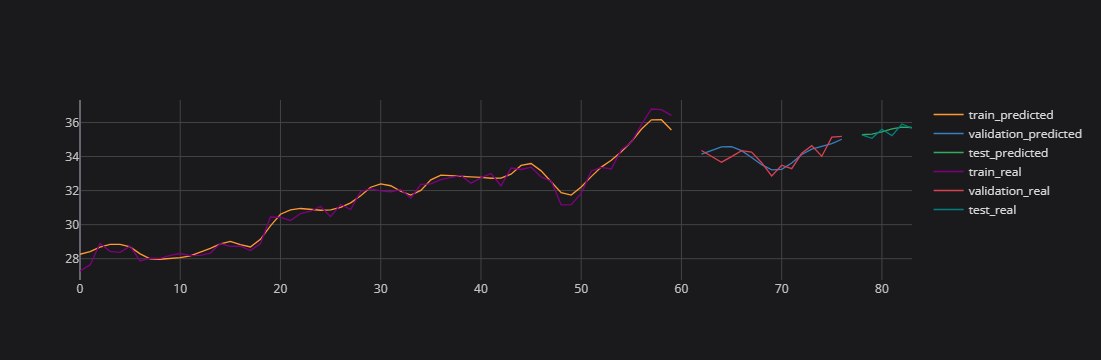

In [45]:
# plotting final result
plot_ticker = 'PETR4'
plot_feature = 'Adj Close'

pd.DataFrame.from_dict(final_prediction_results[plot_ticker][plot_feature]).iplot(title=f'{plot_ticker} {plot_feature} {plot_imf}', layout=space)

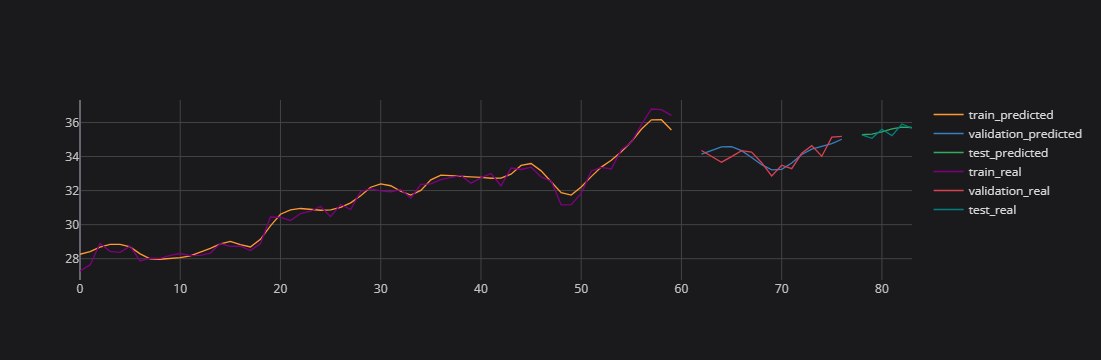

In [48]:
# plotting final result
plot_ticker = 'PETR4'
plot_feature = 'Adj Close'

pd.DataFrame.from_dict(final_prediction_results[plot_ticker][plot_feature]).iplot(title=f'{plot_ticker} {plot_feature} {plot_imf}', layout=space)

In [47]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)